# LAS VEGAS: LDA

In [1]:
import sys
sys.path.append('/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages')

In [1]:
import LDA
import lda
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import psi
import collections
import json
from scipy import sparse
import sklearn.cluster
import sklearn.decomposition

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

### Loading the data:

Loading the data for Las vegas:

In [3]:
with open('../Zipped_data_LV/lasvegas_word_adjective.json', 'r') as fp:
    lv_wadj = json.load(fp)

Creating the vocabulary list with words present at least 10 times in all the reviews:

In [4]:
vocab = []
for i in lv_wadj.keys():
    vocab.extend(lv_wadj[i][0][0])
import collections
lv_vocab10 = []
d = collections.Counter(vocab)
for w in vocab:
    if d[w]>=10:
        lv_vocab10.append(w)
lv_vocab10 = list(set(lv_vocab10)) 

In [5]:
len(lv_vocab10)

10364

In [237]:
np.save('temp/lv_vocab10.npy',lv_vocab10)

Creating dictionaries to map bid to an index and words to index:

In [6]:
lv_word_to_index  = dict(zip(lv_vocab10,range(len(lv_vocab10))))
lv_index_to_word = dict(zip(range(len(lv_vocab10)),lv_vocab10))
lv_bid_to_index = dict(zip(lv_wadj.keys(),range(len(lv_wadj.keys()))))
lv_index_to_bid = dict(zip(range(len(lv_wadj.keys())),lv_wadj.keys()))

In [547]:
with open('temp/bidtoindex.json', 'w') as fp:
    json.dump(lv_bid_to_index, fp)
with open('temp/indextobid.json', 'w') as fp:
    json.dump(lv_index_to_bid, fp)

Loading the dtm:

### DTM TRAIN AND TEST:

In [7]:
reduced_lv = {}
it = 0
for (k,v) in lv_wadj.items():
    if it % 50 == 0:
        print it
    new = []
    for w in v[0][0]:
        if w in lv_vocab10:
            new.append(w)
    reduced_lv[k] = new
    it+=1

0


KeyboardInterrupt: 

Removing some of the top 30 words most present in the reviews:

In [228]:
toremove = ['food','place','service','time','restaurant','menu','order','price','dish','table','thing','person','experience','server','staff','way','bit','portion','lot','hour','star','plate','course','option','customer','liking']

In [258]:
from scipy import sparse

nonzero_data = []
rows_s = []
cols_s = []

for k in reduced_lv.keys():
    counter = collections.Counter(reduced_lv[k])
    for r in toremove:
        counter[r] = 0
    nonzero_data += list(np.floor(np.array(counter.values())*100/np.max(counter.values()))) #Rescaling to account for the important differences in the lengths of the reviews
    rows_s += [lv_bid_to_index[k]]*len(counter.values())
    cols_s += [lv_word_to_index[ck] for ck in counter.keys()]

sparse_mat = sparse.csc_matrix((nonzero_data,(rows_s,cols_s)),shape = (len(lv_bid_to_index),len(lv_word_to_index)))

Saving the document term matrix for the complete data:

In [273]:
lv_dtm = sparse_mat.toarray()
np.save('temp/lv_dtm.npy',lv_dtm)

Dividing the data into training and validation/testing by splitting each document into 2 on an 80/20 basis:

train = {}
test = {}

for k in reduced_lv.keys():
    spl = np.split(range(len(reduced_lv[k])),[int(np.floor(0.8*len(reduced_lv[k]))),len(reduced_lv[k])])
    train[k] = np.array(reduced_lv[k])[spl[0]]
    test[k] = np.array(reduced_lv[k])[spl[1]]

In [276]:
from scipy import sparse

nonzero_data_tr = []
rows_s_tr = []
cols_s_tr = []
nonzero_data_ts = []
rows_s_ts = []
cols_s_ts = []

for k in reduced_lv.keys():
    
    counter_tr = collections.Counter(train[k])
    for r in toremove:
        counter_tr[r] = 0
    nonzero_data_tr += counter_tr.values()
    rows_s_tr += [lv_bid_to_index[k]]*len(counter_tr.values())
    cols_s_tr += [lv_word_to_index[ck] for ck in counter_tr.keys()]
    
    counter_ts = collections.Counter(test[k])
    for r in toremove:
        counter_ts[r] = 0
    nonzero_data_ts += counter_ts.values()
    rows_s_ts += [lv_bid_to_index[k]]*len(counter_ts.values())
    cols_s_ts += [lv_word_to_index[ck] for ck in counter_ts.keys()]

sparse_mat_tr = sparse.csc_matrix((nonzero_data_tr,(rows_s_tr,cols_s_tr)),shape = (len(lv_bid_to_index),len(lv_word_to_index)))
sparse_mat_ts = sparse.csc_matrix((nonzero_data_ts,(rows_s_ts,cols_s_ts)),shape = (len(lv_bid_to_index),len(lv_word_to_index)))

In [277]:
dtm_lv_train = sparse_mat_tr.toarray()
dtm_lv_test = sparse_mat_ts.toarray()

Saving the data:

In [278]:
np.save('temp/dtm_lv_train.npy',dtm_lv_train)
np.save('temp/dtm_lv_test.npy',dtm_lv_test)

Loading the data

In [9]:
dtm_lv_train = np.load('../Lasvegas/dtm_lv_train.npy')
dtm_lv_test = np.load('../Lasvegas/dtm_lv_test.npy')

### Loading the lda functions:

In [10]:
def rho(tau,kappa,t):
	return pow(tau + t, - kappa)

def digamma(mat):
	if (len(mat.shape) == 1):
		return(psi(mat) - psi(np.sum(mat)))
	else:
		return(psi(mat) - psi(np.sum(mat, 0))[np.newaxis,:])

In [11]:
def lda_batch(dtm,ntopic,batch_size,tau,kappa):
	nvoc = dtm.shape[1]
	ndoc = dtm.shape[0]
	nu = 1./ntopic
	alpha = 1./ntopic

	topics = np.random.gamma(100.,1./100.,(nvoc,ntopic))
	gamma  = np.random.gamma(100.,1./100.,(ndoc,ntopic))

	numbatch = ndoc / batch_size
	batches = np.array_split(range(ndoc),numbatch)


	for it_batch in range(numbatch):
		ELogBeta = digamma(topics)
		ExpELogBeta = np.exp(ELogBeta)
		
		temp_topics = np.zeros(topics.shape)

		indices = []

		for d in batches[it_batch]:
			# print d
			ids = np.nonzero(dtm[d,:])[0]
			indices.extend(ids)
			cts = dtm[d,ids]
			ExpELogBetad = ExpELogBeta[ids,:]

			gammad = gamma[d,:]
			ElogTethad = digamma(gammad)
			ExpLogTethad = np.exp(ElogTethad)

			# print gammad

			for inner_it in range(1000):
				
				oldgammad = gammad

				phi =  ExpLogTethad * ExpELogBetad
				phi = phi / (phi.sum(axis=1)+0.00001)[:, np.newaxis]

				gammad = alpha + np.dot(cts,phi)

				ElogTethad = digamma(gammad)
				ExpLogTethad = np.exp(ElogTethad)
				# print gammad

				if np.mean((gammad-oldgammad)**2)<0.0000001:
					break

			#print inner_it
			gamma[d,:] = gammad

			temp_topics[ids,:] += phi * cts[:,np.newaxis]

		indices = np.unique(indices)

		rt = rho(tau,kappa,it_batch)

		topics[indices] = (1 - rt) * topics[indices,:] + rt * ndoc * (nu + temp_topics[indices,:]) / len(batches[it_batch])

	return topics,gamma

In [12]:
def inference(lda,dtm,tau,kappa):

	ntopic = lda[0].shape[1]
	nvoc = dtm.shape[1]
	ndoc = dtm.shape[0]
	nu = 1./ntopic
	alpha = 1./ntopic

	topics = lda[0].copy()
	phi = np.random.gamma(100.,1./100.,(nvoc,ntopic))
	gamma  = np.random.gamma(100.,1./100.,(ndoc,ntopic))

	numbatch = ndoc
	batches = np.array_split(range(ndoc),numbatch)

	for it_batch in range(numbatch):
		ELogBeta = digamma(topics)
		ExpELogBeta = np.exp(ELogBeta)
		
		temp_topics = np.zeros(topics.shape)

		indices = []

		for d in batches[it_batch]:
			# print d
			ids = np.nonzero(dtm[d,:])[0]
			indices.extend(ids)
			cts = dtm[d,ids]
			ExpELogBetad = ExpELogBeta[ids,:]

			gammad = gamma[d,:]
			ElogTethad = digamma(gammad)
			ExpLogTethad = np.exp(ElogTethad)

			# print gammad

			for inner_it in range(1000):
				
				oldgammad = gammad

				phi =  ExpLogTethad * ExpELogBetad
				phi = phi / (phi.sum(axis=1)+0.00001)[:, np.newaxis]

				gammad = alpha + np.dot(cts,phi)

				ElogTethad = digamma(gammad)
				ExpLogTethad = np.exp(ElogTethad)
				# print gammad

				if np.mean((gammad-oldgammad)**2)<0.0000001:
					break

			#print inner_it
			gamma[d,:] = gammad

			temp_topics[ids,:] += phi * cts[:,np.newaxis]

		indices = np.unique(indices)
		if indices.size == 0:
			continue
		rt = rho(tau,kappa,it_batch)

		topics[indices] = (1 - rt) * topics[indices,:] + rt * ndoc * (nu + temp_topics[indices,:]) / len(batches[it_batch])

	return topics,gamma

In [15]:
def perplexity(lda,newdocs,tau,kappa,perword = False):
	
	new = inference(lda,newdocs,tau,kappa)
	
	topics = new[0]
	gammas = new[1]
	
	topics = topics/topics.sum(axis=0)
	
	if len(gammas.shape) == 1:
		gammas = gammas/np.sum(gammas)
		doc_idx = np.nonzero(newdocs)[0]
		doc_cts = newdocs[doc_idx]
		return np.exp(-np.log(np.sum(np.dot(topics[doc_idx,:],gammas)*doc_cts))/np.sum(doc_cts))
	
	else:
		norm = lambda x: x/np.sum(x)
		gammas = np.apply_along_axis(norm,axis = 1,arr = gammas)
		
		num = 0
		denom = 0
		
		for i in range(gammas.shape[0]):
			doc_idx = np.nonzero(newdocs[i,:])[0]
			doc_cts = newdocs[i,doc_idx]
			num += np.sum(np.log(np.dot(topics[doc_idx,:],gammas[i,:]))*doc_cts)
			denom += np.sum(doc_cts)
			
		if ~perword:
			return num
		else:
			return num/denom

In [14]:
def perp(lda,newdocs,tau,kappa):
    
    from scipy.special import gammaln,psi
    
    new = inference(lda,newdocs,tau,kappa)
    
    score = 0
    gamma = new[1]
    topics = new[0]
    Elogtheta = psi(gamma) - psi(np.sum(gamma, 1))[:,np.newaxis]
    expElogtheta = np.exp(Elogtheta)
    Elogbeta = digamma(topics)
    # E[log p(docs | theta, beta)]
    for d in range(0, newdocs.shape[0]):
        gammad = gamma[d, :]
        ids = np.nonzero(newdocs[d,:])[0]
        cts = newdocs[d,ids]
        phinorm = np.zeros(len(ids))
        for i in range(0, len(ids)):
            temp = Elogtheta[d, :] + Elogbeta[ids[i],:]
            tmax = max(temp)
            phinorm[i] = np.log(sum(np.exp(temp - tmax))) + tmax
        score += np.sum(cts * phinorm)


    # E[log p(theta | alpha) - log q(theta | gamma)]
    score += np.sum((1./topics.shape[1] - gamma)*Elogtheta)
    score += np.sum(gammaln(gamma) - gammaln(1./topics.shape[1]))
    score += np.sum(gammaln(1/topics.shape[1]*topics.shape[1]) - gammaln(np.sum(gamma, 1)))

#     Compensate for the subsampling of the population of documents
    score = score * float(newdocs.shape[0]) / lda[0].shape[0]

    # E[log p(beta | eta) - log q (beta | lambda)]
    score = score + np.sum((1/topics.shape[1]-topics)*Elogbeta)
    score = score + np.sum(gammaln(topics) - gammaln(1./topics.shape[1]))
    score = score + np.sum(gammaln(1./topics.shape[1]*topics.shape[0]) - gammaln(np.sum(topics, 0)))

    return(score)

In [22]:
batchsize = 40
kappa = 0.5
tau = 1024

K = [25, 30, 35, 40, 45]

perplexity_dict = {}

In [ ]:
%%time
for k in K:
    np.random.seed(0)
    train_lda = lda_batch(dtm_lv_train,k,batchsize,tau,kappa)
    perplexity_dict[k] = perplexity(train_lda,dtm_lv_test,tau,kappa,True)

In [21]:
perplexity_dict

{20: -7812268.3719959883,
 30: -7684291.437907191,
 40: -7722080.2095699785,
 50: -7780613.7762645185,
 60: -7812716.1618218226}

In [472]:
best_k = max(perplexity_dict, key=perplexity_dict.get)

In [473]:
best_k

40

In [474]:
%%time
np.random.seed(0)
model = lda_batch(lv_dtm,best_k,batchsize,tau,kappa)

CPU times: user 39 s, sys: 253 ms, total: 39.2 s
Wall time: 39.3 s


In [475]:
topic_word = model[0].T  # model.components_ also works
n_top_words = 10
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(lv_vocab10)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print(u'Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: rice chicken soup roll beef sushi sauce noodle lunch pork
Topic 1: dog fry bun chili truck hotdog pretzel tot onion lemonade
Topic 2: campus inconvenience popover thirst student contamination quenching ll yumm class
Topic 3: bar drink beer night bartender waitress music friend game area
Topic 4: change nugget ranch cheeseburger character bathroom hooker cop hiding teen
Topic 5: tapas ceviche empanada paella plantain sangria date saltado sangrium la
Topic 6: sandwich bread sub meat subway location airport cheese turkey deli
Topic 7: store counter donut ass floor owner grocery wheat produce remark
Topic 8: location drive employee minute manager window guy chicken cashier car
Topic 9: discontent dippin tamal sympathy soooooo gesture printer transaction standpoint behalf
Topic 10: popsicle chicharone cabana escort drink gelatin sirloin tasting stall cheek
Topic 11: contamination cross bark inconvenience campus shuttle steak meat chicken piano
Topic 12: attitude rice line kick loca

In [476]:
np.save('temp/topics_lv.npy',model[0])

In [477]:
np.save('temp/assignment_lv.npy',model[1])

We now try to find the best hyperparametrisation:

In [480]:
%%time
Kappa = [0.5,0.6,0.7]
Tau = [216,512,1024]
perplexity_dict2 = {}

for kappa in Kappa:
    for tau in Tau:
        np.random.seed(0)
        train_lda = lda_batch(dtm_lv_train,best_k,batchsize,tau,kappa)
        perplexity_dict2[(tau,kappa)] = perplexity(train_lda,dtm_lv_test,tau,kappa,True)

CPU times: user 18min 6s, sys: 11.9 s, total: 18min 18s
Wall time: 18min 28s


In [481]:
best_combi = max(perplexity_dict2, key=perplexity_dict2.get)
best_combi

(512, 0.7)

In [482]:
%%time
np.random.seed(0)
model_bis = lda_batch(lv_dtm,best_k,batchsize,best_combi[0],best_combi[1])

CPU times: user 34.8 s, sys: 742 ms, total: 35.5 s
Wall time: 36.6 s


In [483]:
np.save('temp/topics2_lv.npy',model_bis[0])
np.save('temp/assignment2_lv.npy',model_bis[1])

In [484]:
topic_word = model_bis[0].T  # model.components_ also works
n_top_words = 10
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(lv_vocab10)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print(u'Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: rice chicken soup beef roll lunch sauce sushi noodle pork
Topic 1: dog hotdog chili pretzel bun fry sauerkraut sausage mustard corndog
Topic 2: popover steak lobster meal flavor dinner cheese salad potato meat
Topic 3: bar drink beer bartender night game music wing waitress pool
Topic 4: nugget change discovery hooker salad cop hiding chicken soup dressing
Topic 5: date tapas cheese sangria sauce sangrium pitcher drink paella strip
Topic 6: sandwich bread sub subway turkey meat location deli employee pickle
Topic 7: donut counter ass baking remark store knife bout method lobby
Topic 8: drive window employee car manager minute location drive-thru girl store
Topic 9: chicken drive gravy minute meal girl transaction house attitude employee
Topic 10: drink event garlic venue variety flavor cabbage fun night selection
Topic 11: meat bark steak meal chicken sauce salad pork waiter sample
Topic 12: attitude rice theme line pick kick local view music season
Topic 13: shrimp crab sisig

### NMF

In [493]:
from sklearn.decomposition import NMF

In [504]:
nmf40 = NMF(n_components=40, init='random', random_state=0,max_iter=1500)

In [505]:
nmf70 = NMF(n_components=70, init='random',random_state=0,max_iter=1500)

In [515]:
mat40 = nmf40.fit_transform(lv_dtm)
mat70 = nmf70.fit_transform(lv_dtm)

In [517]:
mat40.shape

(3822, 40)

In [516]:
nmf40.components_.shape

(40, 10364)

In [518]:
topic_word = nmf40.components_  # model.components_ also works
n_top_words = 10
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(lv_vocab10)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print(u'Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: sandwich bread sub subway location meat cheese lunch employee turkey
Topic 1: cheese bean sauce pork chip flavor drink salsa beef tortilla
Topic 2: rib sauce pork meat brisket potato flavor bbq tender bean
Topic 3: cheese pancake location egg taste breakfast bacon flavor fry cake
Topic 4: salad fry chicken location gyro meat sauce wrap meal juice
Topic 5: soup pho pork rice beef roll egg broth noodle bowl
Topic 6: meat beef friend meal item kind waitress quality selection area
Topic 7: bar drink bartender beer night friend game area waitress atmosphere
Topic 8: sushi roll fish sauce tuna rice shrimp chef tempura salmon
Topic 9: chicken meal sauce drink salad bar location flavor cheese night
Topic 10: pasta sauce bread cheese wine salad pizza meatball dinner tomato
Topic 11: taco salsa burrito chip bean tortilla meat guacamole sauce enchilada
Topic 12: flavor meal wine dessert beef sauce dinner steak meat duck
Topic 13: sushi roll fish tuna dinner chef salad bar meal bread
Topi

In [522]:
topic_word = nmf70.components_  # model.components_ also works
n_top_words = 10
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(lv_vocab10)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print(u'Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: rice chicken soup sauce lunch roll noodle beef shrimp pork
Topic 1: salsa bean sauce chip meat lunch rice burrito tortilla enchilada
Topic 2: pho bar sandwich broth day beer bite night owner drink
Topic 3: bar beer breakfast steak night lunch drink bartender home atmosphere
Topic 4: burger cheese bar flavor fry salsa chip lunch drink beer
Topic 5: meat sauce lunch burrito buffet flavor taco pork location salsa
Topic 6: lunch tea sauce flavor owner gelato lamb item water noodle
Topic 7: meal salad sandwich bread breakfast flavor rib taste sauce quality
Topic 8: drink breakfast bar night friend cheese fry steak egg meal
Topic 9: bar drink pizza bartender waitress beer burger night minute sandwich
Topic 10: night sushi drink friend flavor breakfast roll pho egg meal
Topic 11: drink beer shrimp night seafood bar store pasta day cheese
Topic 12: taco breakfast egg steak sandwich meat location cheese toast line
Topic 13: steak cheese meal dinner bread breakfast drink salad potato wa

In [523]:
np.save('temp/nmf_topics40.npy',nmf40.components_)

In [524]:
np.save('temp/nmf_assignments40.npy',mat40)

### Clustering using KL divergence:

In [485]:
def kl_div_sym(v1,v2):
    l = np.log(v1/v2)
    return np.sum(v1*l) + np.sum(-v2*l)

In [486]:
G = model_bis[1]
kl_mat = np.zeros((3822,3822))
for i in range(3822):
    for j in range(i+1,3822,1):
        kl_mat[i,j] = kl_mat[j,i] = kl_div_sym(G[i,:]/np.sum(G[i,:]),G[j,:]/np.sum(G[j,:]))

In [538]:
closest_id_kl = {}
for i in range(kl_mat.shape[0]):
    v = kl_mat[i,:]
    closest_id_kl[i] = zip(np.array(range(kl_mat.shape[0]))[np.argsort(v)][1:11],v[np.argsort(v)][1:11])

In [539]:
closest_id_kl[0]

[(857, 0.38168444740052349),
 (1799, 0.3852247801476717),
 (3330, 0.41070517156736075),
 (3677, 0.41717690445738859),
 (2919, 0.41929608585073103),
 (1597, 0.42333173587204148),
 (3106, 0.42447702801295206),
 (2949, 0.42486043690122594),
 (3373, 0.42543123016052042),
 (129, 0.42581309251850152)]

(array([ 209.,  160.,  164.,  153.,  141.,  165.,  164.,  190.,  212.,
         213.,  233.,  241.,  245.,  185.,  141.,   84.,   30.,   10.,
           2.,    0.,   12.,  160.,  364.,  255.,   89.]),
 array([  0.        ,   0.95419638,   1.90839276,   2.86258914,
          3.81678552,   4.77098191,   5.72517829,   6.67937467,
          7.63357105,   8.58776743,   9.54196381,  10.49616019,
         11.45035657,  12.40455295,  13.35874933,  14.31294572,
         15.2671421 ,  16.22133848,  17.17553486,  18.12973124,
         19.08392762,  20.038124  ,  20.99232038,  21.94651676,
         22.90071314,  23.85490953]),
 <a list of 25 Patch objects>)

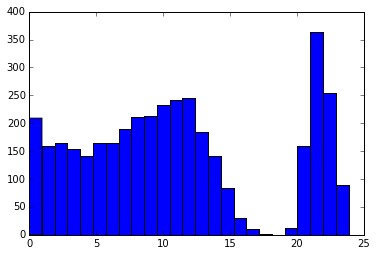

In [543]:
plt.hist(kl_mat[0,:],bins=25)

(array([   1.,    0.,    1.,  316.,  277.,  232.,  204.,  215.,  217.,
         207.,  228.,  233.,  222.,  219.,  213.,  163.,  137.,   70.,
          18.,    4.,    0.,   23.,  181.,  330.,  111.]),
 array([  0.        ,   0.90701664,   1.81403328,   2.72104992,
          3.62806656,   4.5350832 ,   5.44209984,   6.34911648,
          7.25613312,   8.16314976,   9.07016639,   9.97718303,
         10.88419967,  11.79121631,  12.69823295,  13.60524959,
         14.51226623,  15.41928287,  16.32629951,  17.23331615,
         18.14033279,  19.04734943,  19.95436607,  20.86138271,
         21.76839935,  22.67541599]),
 <a list of 25 Patch objects>)

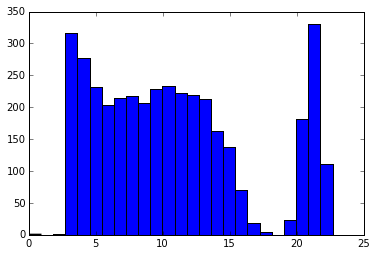

In [544]:
plt.hist(kl_mat[1,:],bins=25)

In [545]:
graph_mat = kl_mat.copy()
graph_mat[graph_mat<1] = 1
graph_mat[graph_mat>1] = 0

In [546]:
np.savetxt("temp/adjacency_kl.csv", graph_mat, delimiter=",")